In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display_html

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
plt.ion()
plt.rcParams['figure.figsize']  = (8, 5)

<IPython.core.display.Javascript object>

In [3]:
path = 'enem_small_data/'
file = 'Microdados_ENEM_Amostra_'

In [4]:
def display_dfs(dfs, names=[]):
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:top"> {df.head().to_html(index=False)}</td>' 
                         for df in dfs) + 
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

## Análise exploratória

### Tratando os dados

In [5]:
df = pd.read_csv(path+file+'2018.csv', sep=',',  encoding='latin-1', usecols=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_IDADE', 'CO_UF_RESIDENCIA',
    'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006', 'Q025', 'Q027', 'TP_DEPENDENCIA_ADM_ESC']).dropna()
df['Media'] = df[['NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].sum(axis=1)/len(df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].columns)

#Alterando respostas 'Não sei' para ficarem em ordem lógica
df['Q001'] = df['Q001'].replace('H','0')
df['Q002'] = df['Q002'].replace('H','0')

#codificando atributos categóricos
encoder = preprocessing.LabelEncoder()
df['Q001'] = encoder.fit_transform(df['Q001'])
df['Q002'] = encoder.fit_transform(df['Q002'])
df['Q006'] = encoder.fit_transform(df['Q006'])
df['Q025'] = encoder.fit_transform(df['Q025'])
df['Q027'] = encoder.fit_transform(df['Q027'])
df['TP_SEXO'] = encoder.fit_transform(df['TP_SEXO'])
df['CO_UF_RESIDENCIA'] = encoder.fit_transform(df['CO_UF_RESIDENCIA'])

df.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q025,Q027,Media
2,20,17,0,1,2.0,417.4,481.5,496.5,504.3,320.0,4,6,7,1,0,443.94
7,9,17,0,3,2.0,390.9,600.5,598.7,564.5,480.0,0,2,1,0,1,526.92
11,9,18,0,3,2.0,521.8,602.7,532.8,486.3,440.0,5,5,2,1,0,516.72
13,16,17,0,3,4.0,640.8,659.4,606.0,736.9,800.0,5,5,6,1,3,688.62
28,12,18,0,3,2.0,475.6,432.9,507.7,420.5,300.0,3,5,2,1,0,427.34


### Visualizações

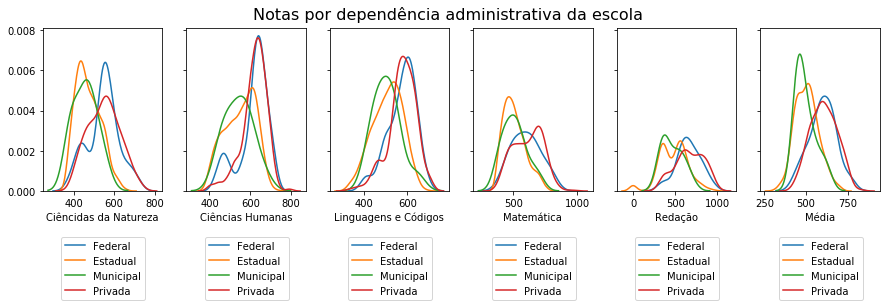

In [6]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 1][columns[i]], hist = False, label = 'Federal', ax=axes[i])
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 2][columns[i]], hist = False, label = 'Estadual', ax=axes[i])
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 3][columns[i]], hist = False, label = 'Municipal', ax=axes[i])
    sns.distplot(df[df['TP_DEPENDENCIA_ADM_ESC'] == 4][columns[i]], hist = False, label = 'Privada', ax=axes[i], axlabel=labels[i])
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
fig.suptitle('Notas por dependência administrativa da escola', fontsize=16)
plt.show()

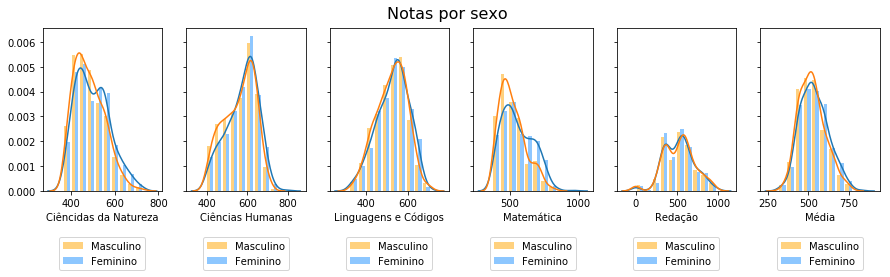

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['TP_SEXO'] == 0][columns[i]],df[df['TP_SEXO'] == 1][columns[i]]], 
                 label=['Masculino', 'Feminino'], density=True, color=['orange','dodgerblue'], alpha=0.5)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
    
    sns.distplot(df[df['TP_SEXO'] == 1][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['TP_SEXO'] == 0][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Notas por sexo'), fontsize=16)
plt.show()


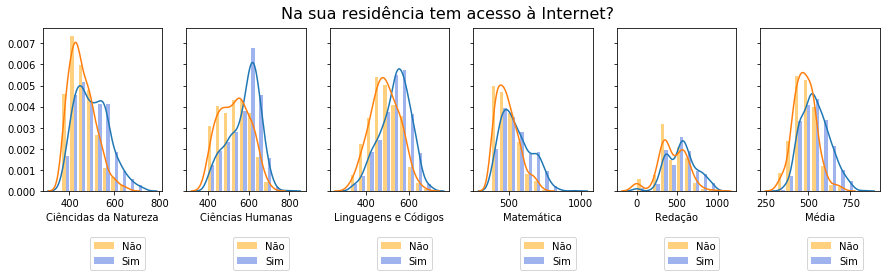

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['Q025'] == 0][columns[i]],df[df['Q025'] == 1][columns[i]]], 
                 label=['Não', 'Sim'], density=True, color=['orange','royalblue'], alpha=0.5)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
        
    sns.distplot(df[df['Q025'] == 1][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['Q025'] == 0][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Na sua residência tem acesso à Internet?'), fontsize=16)
plt.show()


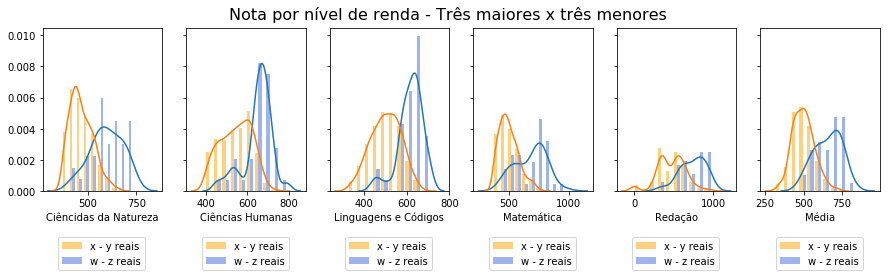

In [9]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['Q006'].isin([0, 1, 2])][columns[i]],df[df['Q006'].isin([14, 15, 16])][columns[i]]], 
                 label=['x - y reais', 'w - z reais'], density=True, color=['orange','royalblue'], alpha=0.5)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
    
    sns.distplot(df[df['Q006'].isin([14, 15, 16])][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['Q006'].isin([0, 1, 2])][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Nota por nível de renda - Três maiores x três menores'), fontsize=16)
plt.show()

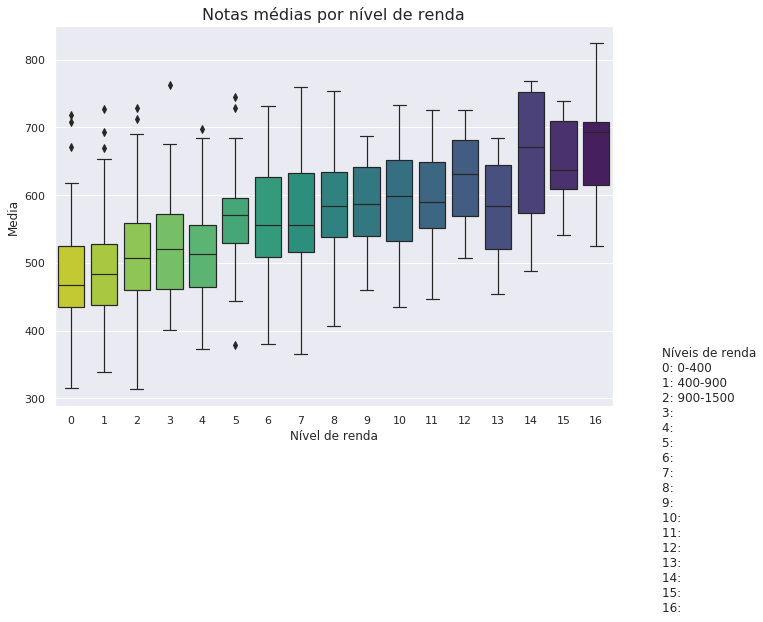

In [10]:
legend = '\n'.join(('Níveis de renda', '0: 0-400', '1: 400-900', '2: 900-1500', '3: ', '4: ',
                    '5: ', '6: ', '7: ', '8: ', '9: ', '10: ', '11: ', '12: ', '13: ', '14: ',
                   '15: ', '16: '))
sns.set(style='darkgrid')
plt.figure(figsize  = [10, 7])
sns.boxplot(x = 'Q006', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por nível de renda', fontsize=16)
plt.xlabel('Nível de renda')
plt.text(18, -15, legend)
plt.show()

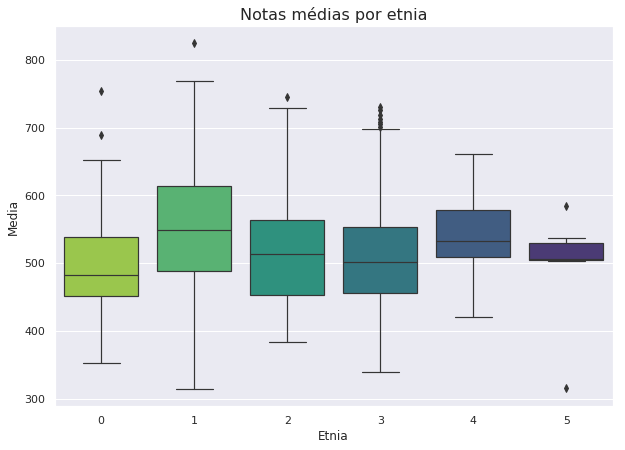

In [11]:
sns.set(style='darkgrid')
plt.figure(figsize  = [10, 7])
sns.boxplot(x = 'TP_COR_RACA', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por etnia', fontsize=16)
plt.xlabel('Etnia')
plt.show()

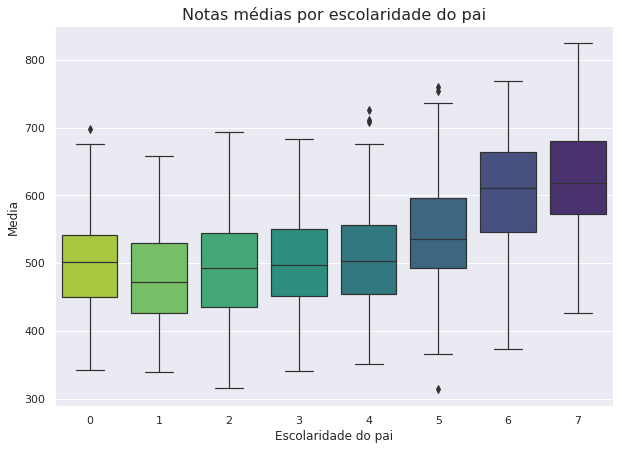

In [12]:
sns.set(style='darkgrid')
plt.figure(figsize  = [10, 7])
sns.boxplot(x = 'Q001', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por escolaridade do pai', fontsize=16)
plt.xlabel('Escolaridade do pai')
plt.show()

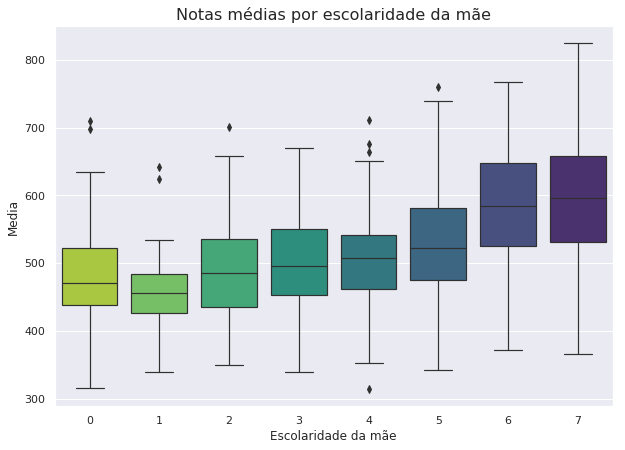

In [13]:
sns.set(style='darkgrid')
plt.figure(figsize  = [10, 7])
sns.boxplot(x = 'Q002', y = 'Media', data = df, palette=("viridis_r"),  linewidth=1.2)
plt.title('Notas médias por escolaridade da mãe', fontsize=16)
plt.xlabel('Escolaridade da mãe')
plt.show()

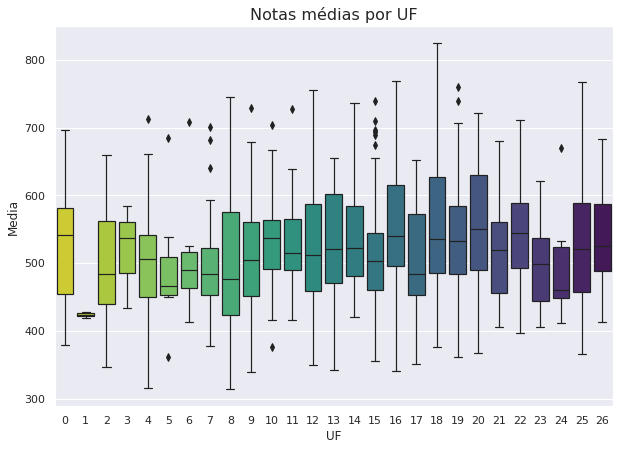

In [14]:
sns.set(style='darkgrid')
plt.figure(figsize  = [10, 7])
sns.boxplot(x = 'CO_UF_RESIDENCIA', y = 'Media', data = df, palette=("viridis_r"), linewidth=1.2)
plt.title('Notas médias por UF', fontsize=16)
plt.xlabel('UF')
plt.show()

## Tentativa de regressão

### Preparando os dados

In [15]:
df = pd.read_csv(path+file+'2018.csv', sep=',',  encoding='latin-1', usecols=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_IDADE', 'CO_UF_RESIDENCIA',
    'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006', 'Q025', 'Q027', 'TP_DEPENDENCIA_ADM_ESC']).dropna()

X = df.drop(columns=['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO'])
y = df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].mean(axis=1)
X.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q006,Q025,Q027
2,41,17,F,1,2.0,D,F,H,B,A
7,23,17,F,3,2.0,H,B,B,A,B
11,23,18,F,3,2.0,E,E,C,B,A
13,31,17,F,3,4.0,E,E,G,B,D
28,26,18,F,3,2.0,C,E,C,B,A


In [16]:
#Cast dos tipos das colunas para depois fazer onehotencoding
X[['CO_UF_RESIDENCIA','TP_COR_RACA','TP_DEPENDENCIA_ADM_ESC']] = X[['CO_UF_RESIDENCIA','TP_COR_RACA',
                                                                    'TP_DEPENDENCIA_ADM_ESC']].astype('object')
#Codificando renda para ser categórica ordinal
encoder = preprocessing.OrdinalEncoder()
X[['Q006']] = encoder.fit_transform(X[['Q006']])

#Aplicando one hot enconding às variáveis categóricas
X_enc = pd.get_dummies(X, drop_first = True)

#Add intercepto 
X_enc.insert(0,'INTERCEPTO',1)

### Regressão linear regularizada

In [17]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

#Normalizando variáveis numéricas
mean = X_train[['NU_IDADE']].mean()
std = X_train[['NU_IDADE']].std(ddof=1)
X_train[['NU_IDADE']] -= mean
X_train[['NU_IDADE']] /= std
X_test[['NU_IDADE']] = (X_test[['NU_IDADE']] - mean) / std

/home/barbara/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [18]:
'''
reg = LinearRegression(fit_intercept=True)
kfold = model_selection.KFold(n_splits=10, random_state=42)
results = model_selection.cross_val_score(reg, X_train, y_train, cv=kfold, scoring='r2')
'''
reg = LassoCV(fit_intercept=True, cv = 10)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

print('Previsão com conjunto de teste - Regressão linear regularizada')
print('Variance score: %.2f' % reg.score(X_test, y_test))
print('MSE score: %.2f' % mean_squared_error(y_test, y_pred))

Previsão com conjunto de teste - Regressão linear regularizada
Variance score: 0.37
MSE score: 5021.64


### Regressão usando Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor(n_estimators = 100, random_state = 0) 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Previsão com conjunto de teste - Random Forest')
print('Variance score: %.2f' % r2_score(y_test, y_pred_rf))
print('MSE score: %.2f' % mean_squared_error(y_test, y_pred_rf))

Previsão com conjunto de teste - Random Forest
Variance score: 0.31
MSE score: 5490.90


### Mais avaliações

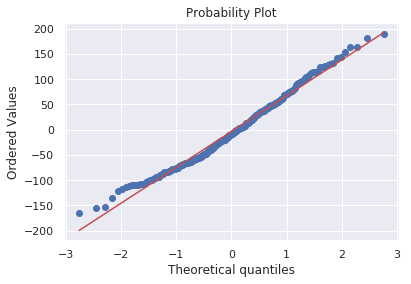

In [20]:
ss.probplot(y_test - y_pred, plot=plt)
plt.show()

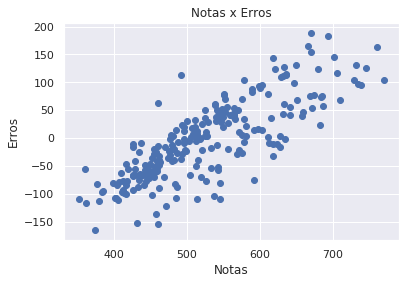

In [21]:
plt.scatter(y_test,y_test - y_pred)
plt.ylabel('Erros')
plt.xlabel('Notas')
plt.title('Notas x Erros')
plt.show()

In [22]:
print('Previsão com conjunto de treino - Regressão linear regularizada')
print('Variance score: %.2f' % reg.score(X_train, y_train))

y_t_pred_rf = rf.predict(X_train)
print('Previsão com conjunto de treino - Random Forest')
print('Variance score: %.2f' % r2_score(y_train, y_t_pred_rf))

Previsão com conjunto de treino - Regressão linear regularizada
Variance score: 0.39
Previsão com conjunto de treino - Random Forest
Variance score: 0.90


Como se pode ver no plot acima, o modelo de regressão ficou tendencioso para notas distantes da média. Além disso, o r² ruim para o próprio conjunto de treino na regressão linear regularizada evidencia que a regressão linear parece não se adequar para os dados, de forma que a relação entre os atributos socioeconômicos e a nota não é linear. Além disso, como a maioria dos atributos é categórica (exceto idade e faixa de renda), uma regressão polinomial não se adequa.

## Classificação

Diante do problema que foi exposto acima, vamos classificar as notas em três categorias, baixa, média e alta, a partir dos atributos socioeconômicos.

In [23]:
um_terco = np.percentile(y,33)
dois_tercos = np.percentile(y,66)

def map_classes_estado(nota, um_terco_=um_terco, dois_tercos_=dois_tercos):
    if nota < um_terco_:
        return 'baixo'
    elif nota < dois_tercos_:
        return 'medio'
    elif nota >= dois_tercos_:
        return 'alto'

y_classes = y.map(map_classes_estado)

In [24]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_classes, test_size=0.2, random_state=42)

#Normalizando variáveis numéricas
mean = X_train[['NU_IDADE']].mean()
std = X_train[['NU_IDADE']].std(ddof=1)
X_train[['NU_IDADE']] -= mean
X_train[['NU_IDADE']] /= std
X_test[['NU_IDADE']] = (X_test[['NU_IDADE']] - mean) / std

/home/barbara/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [25]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(1,51,2)}

classifier = GridSearchCV(knn, param_grid=parameters, cv = 10)
classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)
    
print(classification_report(y_test, y_pred))
#IC? Bootstrap no f1?

              precision    recall  f1-score   support

        alto       0.65      0.66      0.66        77
       baixo       0.62      0.59      0.61        93
       medio       0.42      0.44      0.43        68

   micro avg       0.57      0.57      0.57       238
   macro avg       0.57      0.56      0.56       238
weighted avg       0.57      0.57      0.57       238



/home/barbara/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
from sklearn.linear_model import LogisticRegressionCV

reg = LogisticRegressionCV(cv = 5, solver = 'newton-cg', max_iter=1000, multi_class ='multinomial')
reg = reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        alto       0.67      0.68      0.67        77
       baixo       0.64      0.58      0.61        93
       medio       0.35      0.38      0.36        68

   micro avg       0.55      0.55      0.55       238
   macro avg       0.55      0.55      0.55       238
weighted avg       0.56      0.55      0.56       238

